In [ ]:
#Importing libraries
import sys, os, re, json
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from collections import defaultdict, Counter
from typing import List, Tuple, Dict
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.3 MB 4.4 MB/s 
     |████████████████████████████████| 3.3 MB 25.0 MB/s 
     |████████████████████████████████| 596 kB 48.4 MB/s 
     |████████████████████████████████| 61 kB 526 kB/s 
     |████████████████████████████████| 895 kB 38.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#Loading Train,Dev and test datasets
dev_path="data/dev_data.csv"
test_path="data/test_data.csv"
train_path="data/train_data.csv"

train=pd.read_csv(train_path)
#train=train
dev=pd.read_csv(dev_path)
#dev=dev
test=pd.read_csv(test_path)
#test=test

In [ ]:
train

,Unnamed: 0,star_rating,review_body,Summary
0,154598,2,bought this recently and will not purchase aga...,not strong enough
1,29205,3,We have purchased this popcorn twice. It's jus...,Popcorn
2,143589,1,My dog refuses to eat it and it smells pretty ...,Doesn't like
3,55168,2,I tried this in place of Iams. My hefty maine...,"may be healthy but my ""eat anything"" cat won't..."
4,79292,4,"I got the dark chocolate cherry cashew, and I ...",Love the taste
...,...,...,...,...
111995,58183,4,One weekend when I was terribly sick with the ...,It helps
111996,109734,1,Not sure why they decided to mess with a good ...,Baby hates new recipe...
111997,26371,5,"I love all things coconut, and was first drawn...",The perfect low-glycemic sweetener for baking!
111998,112476,4,"As I get older and fatter, I seek opportunitie...","Flavor in, Calories Down, Fat Nearly Out"


In [ ]:
#Preprocessing Data:
!pip install emoji
!pip install autocorrect
!pip install num2words
!pip install contractions

#Text preprocessing helper functions
import string
import nltk
from nltk.corpus import stopwords
from autocorrect import Speller
import num2words
import contractions
import emoji 

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

#Removing Puntuation Marks
my_punct = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '.',
           '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', 
           '`', '{', '|', '}', '~', '»', '«', '“', '”'] # Puntuation marks
punct_pattern = re.compile("[" + re.escape("".join(my_punct)) + "]")

def decontracted(phrase):
    """ Expands contractions """
    
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    return phrase

def clean_text(review):
    #Cast to lower case
    #review = review.lower()
    #Remove numbers
    review = re.sub(r'\d+', ' ', review)
    #Remove punctuation 
    review = re.sub(punct_pattern, "", review) 
    #Removing HTTP and WWW from URL
    review = re.sub('https?://\S+|www\.\S+', '', review) 
    #Removing HTML tags
    review = re.sub('<.*?>+', '', review) 
    #Expand contractions
    review = decontracted(review)
    #Convert emojis to words
    review = emoji.demojize(review)
    #Split on whitespace
    tokens = nltk.word_tokenize(review)
    #Remove stop words
    stop = set(stopwords.words('english'))
    filtered = [w for w in tokens if w not in stop]
    #Adding POS tags and filtering unimportant words using POS Tags
    pos_tags = nltk.pos_tag(filtered)
    pos_tags = [w for w,pos in pos_tags if pos not in ['DT','PRP','CD','WDT','WP','TO','IN','CC','PRP$','WRB']]
    pos_tags = str(pos_tags)   
    #Remove punctuation again after adding POS Tags
    review = (" ").join(filtered)
    review = re.sub(punct_pattern,"", review) 

    return review

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#Pre-Processing Train dataset for training model 

#train.drop(columns=["Unnamed: 0"], inplace=True)
train['Summary'] = train['Summary'].fillna('')
train['review_body'] = train['review_body'].fillna('')
train['review_body'] = train['Summary'] + ' ' + train['review_body']
train['review_body'] = train['review_body'].apply(clean_text)
train=train.rename(columns={"star_rating": "labels", "review_body": "text"})
train.drop(columns=["Summary"], inplace=True)
train["labels"]=train["labels"]-1
df_train=train

In [ ]:
#Pre-Processing Dev dataset for Evaluation

dev.drop(columns=["Unnamed: 0"], inplace=True)
dev['Summary'] = dev['Summary'].fillna('')
dev['review_body'] = dev['review_body'].fillna('')
dev['review_body'] = dev['Summary'] + ' ' + dev['review_body']
dev['review_body'] = dev['review_body'].apply(clean_text)
dev=dev.rename(columns={"star_rating": "labels", "review_body": "text"})
dev.drop(columns=["Summary"], inplace=True)
dev["labels"]=dev["labels"]-1
df_dev=dev

In [ ]:
#Pre-Processing Test dataset for Evaluation

test.drop(columns=["Unnamed: 0"], inplace=True)
test['Summary'] = test['Summary'].fillna('')
test['review_body'] = test['review_body'].fillna('')
test['review_body'] = test['Summary'] + ' ' + test['review_body']
test['review_body'] = test['review_body'].apply(clean_text)
test=test.rename(columns={"star_rating": "labels", "review_body": "text"})
test.drop(columns=["Summary"], inplace=True)
test["labels"]=test["labels"]-1
df_test=test

In [ ]:
#Importing Transformers

from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

In [ ]:
# Creating Encodings 
train_encodings = tokenizer(list(df_train["text"]), truncation=True, padding=True)
val_encodings = tokenizer(list(df_dev["text"]), truncation=True, padding=True)
test_encodings = tokenizer(list(df_test["text"]), truncation=True, padding=True)

In [ ]:
# Formatting Data for Train, Test and Dev
import torch

class datasets(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = datasets(train_encodings, list(df_train['labels']))
val_dataset = datasets(val_encodings, list(df_dev['labels']))
test_dataset = datasets(test_encodings, list(df_test['labels']))

In [ ]:
# Training 
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

model = RobertaForSequenceClassification.from_pretrained("roberta-base",num_labels=5)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Step,Training Loss
10,1.632000
20,1.610500
30,1.613400
40,1.610600
50,1.610400
60,1.612700
70,1.608900
80,1.623400
90,1.591200
100,1.578000


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

TrainOutput(global_step=14000, training_loss=0.8762988992418562, metrics={'train_runtime': 12356.825, 'train_samples_per_second': 18.128, 'train_steps_per_second': 1.133, 'total_flos': 5.8938463911936e+16, 'train_loss': 0.8762988992418562, 'epoch': 2.0})

In [ ]:
!pip install datasets

     |████████████████████████████████| 298 kB 13.9 MB/s 
     |████████████████████████████████| 243 kB 60.7 MB/s 
     |████████████████████████████████| 132 kB 71.0 MB/s 
     |████████████████████████████████| 1.1 MB 55.1 MB/s 
     |████████████████████████████████| 271 kB 70.7 MB/s 
     |████████████████████████████████| 160 kB 69.6 MB/s 
     |████████████████████████████████| 192 kB 75.9 MB/s 


In [ ]:
#Path names of Output Files
Y_true_dev_path='Y_true_Dev.csv'
Y_true_test_path='Y_true_Test.csv'
Pred_dev_path='Dev_Output.csv'
Pred_test_path='Test_Output.csv'
evaluate ='evaluate.py'

In [ ]:
# Defining Compute Metric for trainer.evaluate()
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    return metric.compute(predictions=predictions, references=labels)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

In [ ]:
# Evaluation for dev set 
from transformers import TrainingArguments

training_args = TrainingArguments("test_trainer", evaluation_strategy="epoch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.evaluate()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Evaluation *****
  Num examples = 14000
  Batch size = 8


{'eval_accuracy': 0.6795,
 'eval_loss': 0.8308190703392029,
 'eval_runtime': 270.5969,
 'eval_samples_per_second': 51.737,
 'eval_steps_per_second': 6.467}

In [ ]:
# Printing Evaluation Metrics for Dev Set

predictions = trainer.predict(val_dataset)

import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

preds = preds +1

Y_pred=list(map(lambda a: str(a)+'\n', preds))

"\n# Printing Evaluation Metrics for Dev Set\n\npredictions = trainer.predict(val_dataset)\n\nimport numpy as np\n\npreds = np.argmax(predictions.predictions, axis=-1)\n\npreds = preds +1\n\nY_pred=list(map(lambda a: str(a)+'\n', preds))\n\nwith open(Pred_dev_path,'w') as f:\n  f.writelines(Y_pred)\n\nY_true =list(map(lambda a: str(a)+'\n', df_dev['labels']+1))\nwith open(Y_true_dev_path,'w') as f:\n  f.writelines(Y_true)\n\n#Printing Confusion Matrix\ncm = confusion_matrix(df_dev['labels']+1, preds)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])\ndisp.plot()\n\n!python3 '/content/drive/MyDrive/evaluate.py' -p '/content/drive/MyDrive/Colab Notebooks/cis 530 project riya/roberta-base/output_17.csv' -d '/content/drive/MyDrive/Colab Notebooks/cis 530 project riya/Y_true_Dev.csv'\n"

Accuracy Score:  0.6795


RMSE:  0.7388697932846974


Average F1: 0.6784328759510078


Confusion Matrix saved as confusion_matrix.png 



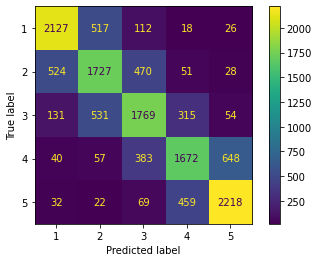

In [ ]:
with open(Pred_dev_path,'w') as f:
  f.writelines(Y_pred)

Y_true =list(map(lambda a: str(a)+'\n', df_dev['labels']+1))
with open(Y_true_dev_path,'w') as f:
  f.writelines(Y_true)

#Printing Confusion Matrix
cm = confusion_matrix(df_dev['labels']+1, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot()

!python3 '/content/drive/MyDrive/evaluate.py' -p '/content/drive/MyDrive/Colab Notebooks/Dev_Output.csv' -d '/content/drive/MyDrive/Colab Notebooks/Y_true_Dev.csv'

In [ ]:
# Evaluation for Test set 
from transformers import TrainingArguments

training_args = TrainingArguments("test_trainer", evaluation_strategy="epoch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.evaluate()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Evaluation *****
  Num examples = 14000
  Batch size = 8


{'eval_accuracy': 0.6836428571428571,
 'eval_loss': 0.8017057776451111,
 'eval_runtime': 270.4359,
 'eval_samples_per_second': 51.768,
 'eval_steps_per_second': 6.471}

***** Running Prediction *****
  Num examples = 14000
  Batch size = 8


Accuracy Score:  0.6836428571428571


RMSE:  0.7049316076248613


Average F1: 0.68304074406171


Confusion Matrix saved as confusion_matrix.png 



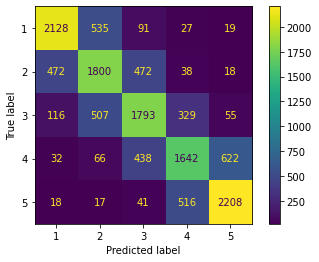

In [ ]:
# Printing Evaluation Metrics for Test Set

predictions = trainer.predict(test_dataset)

import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

preds = preds +1

Y_pred=list(map(lambda a: str(a)+'\n', preds))

with open(Pred_test_path,'w') as f:
  f.writelines(Y_pred)


Y_true =list(map(lambda a: str(a)+'\n', df_test['labels']+1))
with open(Y_true_test_path,'w') as f:
  f.writelines(Y_true)

#Printing Confusion Matrix
cm = confusion_matrix(df_test['labels']+1, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot()

!python3 '/content/drive/MyDrive/evaluate.py' -p '/content/drive/MyDrive/Colab Notebooks/Test_Output.csv' -d '/content/drive/MyDrive/Colab Notebooks/Y_true_Test.csv'